# Multi-Agent Workflows + RAG - LangGraph

Today we'll be looking at an example of a Multi-Agent workflow that's powered by LangGraph, LCEL, and more!

We're going to be, more specifically, looking at a "heirarchical agent teams" from the [AutoGen: Enabling Next-Gen LLM
Applications via Multi-Agent Conversation](https://arxiv.org/pdf/2308.08155) paper.

This will be the final "graph" of our system:

![image](https://i.imgur.com/r5LMMCt.png)

It's important to keep in mind that the actual implementation will be constructed of 3 separate graphs, the final one having 2 graphs as nodes! LangGraph is a heckuva tool!



# 🤝 BREAKOUT ROOM #1

## Dependencies

Since we'll be relying on OpenAI's suite of models to power our agents today, we'll want to provide our OpenAI API Key.

We're also going to be using the Tavily search tool - so we'll want to provide that API key as well!

Instruction for how to obtain the Tavily API key can be found:

1. [Tavily API Key](https://app.tavily.com/sign-in)



In [13]:
import os
import getpass

os.environ["OPENAI_API_KEY"] = getpass.getpass("OpenAI API Key:")
os.environ["TAVILY_API_KEY"] = getpass.getpass("TAVILY_API_KEY")

In [14]:
import nest_asyncio
nest_asyncio.apply()

## Task 1: Simple LangGraph RAG

Now that we have our dependencies set-up - let's create a simple RAG graph that works over our AI Usage Data from previous sessions.

> NOTE: While this particular example is very straight forward - you can "plug in" any complexity of chain you desire as a node in a LangGraph.

### Retrieval

The 'R' in 'RAG' - this is, at this point, fairly straightforward!

#### Data Collection and Processing

A classic first step, at this point, let's grab our desired document!

In [15]:
from langchain_community.document_loaders import DirectoryLoader
from langchain_community.document_loaders import PyMuPDFLoader

directory_loader = DirectoryLoader("data", glob="**/*.pdf", loader_cls=PyMuPDFLoader)

how_people_use_ai_documents = directory_loader.load()

Now we can chunk it down to size!

In [16]:
import tiktoken
from langchain.text_splitter import RecursiveCharacterTextSplitter

def tiktoken_len(text):
    tokens = tiktoken.encoding_for_model("gpt-4o").encode(
        text,
    )
    return len(tokens)

text_splitter = RecursiveCharacterTextSplitter(
    chunk_size = 750,
    chunk_overlap = 0,
    length_function = tiktoken_len,
)

how_people_use_ai_chunks = text_splitter.split_documents(how_people_use_ai_documents)

Now we've successfully split our single PDF into...

In [17]:
len(how_people_use_ai_chunks)

71

#### Embedding Model and Vector Store

Now that we have our chunked document - lets create a vector store, which will first require us to create an embedding model to get the vector representations of our text!

We'll use OpenAI's [`text-embedding-3-small`](https://platform.openai.com/docs/guides/embeddings/embedding-models) model - as it's cheap, and performant.

In [18]:
from langchain_openai.embeddings import OpenAIEmbeddings

embedding_model = OpenAIEmbeddings(model="text-embedding-3-small")

Now we can create our QDrant backed vector store!

In [7]:
from langchain_community.vectorstores import Qdrant

qdrant_vectorstore = Qdrant.from_documents(
    documents=how_people_use_ai_chunks,
    embedding=embedding_model,
    location=":memory:"
)

Let's make sure we can access it as a retriever.

In [19]:
qdrant_retriever = qdrant_vectorstore.as_retriever()

### Augmented

Now that we have our retrieval process set-up, we need to set up our "augmentation" process - AKA a prompt template.

In [20]:
from langchain_core.prompts import ChatPromptTemplate

HUMAN_TEMPLATE = """
#CONTEXT:
{context}

QUERY:
{query}

Use the provide context to answer the provided user query. Only use the provided context to answer the query. If you do not know the answer, or it's not contained in the provided context respond with "I don't know"
"""

chat_prompt = ChatPromptTemplate.from_messages([
    ("human", HUMAN_TEMPLATE)
])

### Generation

Last, but certainly not least, let's put the 'G' in 'RAG' by adding our generator - in this case, we can rely on OpenAI's [`gpt-4o-mini`](https://platform.openai.com/docs/models/gpt-4o-mini) model!

In [21]:
from langchain_openai import ChatOpenAI

generator_llm = ChatOpenAI(model="gpt-4.1-nano")

### RAG - Retrieval Augmented Generation

All that's left to do is combine our R, A, and G into a single graph - and we're off!

In [23]:
from langgraph.graph import START, StateGraph
from typing_extensions import List, TypedDict
from langchain_core.documents import Document
from langchain_core.output_parsers import StrOutputParser

class State(TypedDict):
  question: str
  context: List[Document]
  response: str

def retrieve(state: State):
  retrieved_docs = qdrant_retriever.invoke(state["question"])
  return {"context" : retrieved_docs}

def generate(state: State):
  generator_chain = chat_prompt | generator_llm | StrOutputParser()
  response = generator_chain.invoke({"query" : state["question"], "context" : state["context"]})
  return {"response" : response}

rag_graph = StateGraph(State).add_sequence([retrieve, generate])
rag_graph.add_edge(START, "retrieve")
compiled_rag_graph = rag_graph.compile()

Let's test this out and make sure it works.

In [24]:
compiled_rag_graph.invoke({"question" : "How does the average person use AI?"})

{'question': 'How does the average person use AI?',
 'context': [Document(metadata={'producer': 'macOS Version 15.4.1 (Build 24E263) Quartz PDFContext, AppendMode 1.1', 'creator': 'LaTeX with hyperref', 'creationdate': '2025-09-12T20:05:32+00:00', 'source': 'data/howpeopleuseai.pdf', 'file_path': 'data/howpeopleuseai.pdf', 'total_pages': 64, 'format': 'PDF 1.6', 'title': 'How People Use ChatGPT', 'author': '', 'subject': '', 'keywords': '', 'moddate': '2025-09-15T10:32:36-04:00', 'trapped': '', 'modDate': "D:20250915103236-04'00'", 'creationDate': 'D:20250912200532Z', 'page': 17, '_id': 'd86ade444e74403e92c3edbe3cccaa1a', '_collection_name': '2c212895ce8d44cd98ddaab725d923f2'}, page_content='suggests that most user Writing conversations with ChatGPT are requests to modify user inputs\nrather than to create something new. Education is a major use case for ChatGPT. 10.2% of all user\nmessages and 36% of Practical Guidance messages are requests for Tutoring or Teaching. Another\nlarge sha

### RAG Limitation

Notice how we're hard-coding our data, while this is simply meant to be an illustrative example - you could easily extend this to work with any provied paper or document in order to have a more dynamic system.

For now, we'll stick with this single hard-coded example in order to keep complexity down in an already very long notebook!

##### 🏗️ Activity #1 (Bonus Marks)

Allow the system to dynamically fetch Arxiv papers instead of hard coding them.

> HINT: Tuesday's assignment will be very useful here.

## Task 2: Helper Functions for Agent Graphs

We'll be using a number of agents, nodes, and supervisors in the rest of the notebook - and so it will help to have a collection of useful helper functions that we can leverage to make our lives easier going forward.

Let's start with the most simple one!

#### Import Wall

Here's a wall of imports we'll be needing going forward!

In [25]:
from typing import Any, Callable, List, Optional, TypedDict, Union

from langchain.agents import AgentExecutor, create_openai_functions_agent
from langchain.output_parsers.openai_functions import JsonOutputFunctionsParser
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from langchain_core.messages import AIMessage, BaseMessage, HumanMessage
from langchain_core.runnables import Runnable
from langchain_core.tools import BaseTool
from langchain_openai import ChatOpenAI

from langgraph.graph import END, StateGraph

### Agent Node Helper

Since we're going to be wrapping each of our agents into a node - it will help to have an easy way to create the node!

In [26]:
def agent_node(state, agent, name):
    result = agent.invoke(state)
    return {"messages": [HumanMessage(content=result["output"], name=name)]}

### Agent Creation Helper Function

Since we know we'll need to create agents to populate our agent nodes, let's use a helper function for that as well!

Notice a few things:

1. We have a standard suffix to append to our system messages for each agent to handle the tool calling and boilerplate prompting.
2. Each agent has its our scratchpad.
3. We're relying on OpenAI's function-calling API for tool selection
4. Each agent is its own executor.

In [27]:
def create_agent(
    llm: ChatOpenAI,
    tools: list,
    system_prompt: str,
) -> str:
    """Create a function-calling agent and add it to the graph."""
    system_prompt += ("\nWork autonomously according to your specialty, using the tools available to you."
    " Do not ask for clarification."
    " Your other team members (and other teams) will collaborate with you with their own specialties."
    " You are chosen for a reason!")
    prompt = ChatPromptTemplate.from_messages(
        [
            (
                "system",
                system_prompt,
            ),
            MessagesPlaceholder(variable_name="messages"),
            MessagesPlaceholder(variable_name="agent_scratchpad"),
        ]
    )
    agent = create_openai_functions_agent(llm, tools, prompt)
    executor = AgentExecutor(agent=agent, tools=tools)
    return executor

### Supervisor Helper Function

Finally, we need a "supervisor" that decides and routes tasks to specific agents.

Since each "team" will have a collection of potential agents - this "supervisor" will act as an "intelligent" router to make sure that the right agent is selected for the right task.

Notice that, at the end of the day, this "supervisor" is simply directing who acts next - or if the state is considered "done".

In [28]:
def create_team_supervisor(llm: ChatOpenAI, system_prompt, members) -> str:
    """An LLM-based router."""
    options = ["FINISH"] + members
    function_def = {
        "name": "route",
        "description": "Select the next role.",
        "parameters": {
            "title": "routeSchema",
            "type": "object",
            "properties": {
                "next": {
                    "title": "Next",
                    "anyOf": [
                        {"enum": options},
                    ],
                },
            },
            "required": ["next"],
        },
    }
    prompt = ChatPromptTemplate.from_messages(
        [
            ("system", system_prompt),
            MessagesPlaceholder(variable_name="messages"),
            (
                "system",
                "Given the conversation above, who should act next?"
                " Or should we FINISH? Select one of: {options}",
            ),
        ]
    ).partial(options=str(options), team_members=", ".join(members))
    return (
        prompt
        | llm.bind_functions(functions=[function_def], function_call="route")
        | JsonOutputFunctionsParser()
    )

## Task 3: Research Team - A LangGraph for Researching AI Usage Policy

Now that we have our RAG chain set-up and some awesome helper functions, we want to create a LangGraph related to researching a specific topic, in this case: How People Use AI!

We're going to start by equipping our Research Team with a few tools:

1. Tavily Search - aka "Google", for the most up to date information possible.
2. Our RAG chain - specific and high quality information about our topic.

Let's create those tools now!

### Tool Creation

As you can see below, some tools already come pre-packaged ready to use!

In [29]:
from langchain_community.tools.tavily_search import TavilySearchResults

tavily_tool = TavilySearchResults(max_results=5)

/var/folders/2k/24tggmp93z152ndxyqxtq4q80000gn/T/ipykernel_73550/1911882425.py:3: LangChainDeprecationWarning: The class `TavilySearchResults` was deprecated in LangChain 0.3.25 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-tavily package and should be used instead. To use it run `pip install -U :class:`~langchain-tavily` and import as `from :class:`~langchain_tavily import TavilySearch``.
  tavily_tool = TavilySearchResults(max_results=5)


Creating a custom tool, however, is very straightforward.

> NOTE: You *must* include a docstring, as that is what the LLM will consider when deciding when to use this tool.

In [30]:
from typing import Annotated, List, Tuple, Union
from langchain_core.tools import tool

@tool
def retrieve_information(
    query: Annotated[str, "query to ask the retrieve information tool"]
    ):
  """Use Retrieval Augmented Generation to retrieve information about how people use AI"""
  return compiled_rag_graph.invoke({"question" : query})

> NOTE: We could just as easily use the LCEL chain directly, since nodes can be LCEL objects - but creating a tool helps explain the tool creation process at the same time.

### Research Team State

Since we're using LangGraph - we're going to need state!

Let's look at how we've created our state below.

In [31]:
import functools
import operator

from langchain_core.messages import AIMessage, BaseMessage, HumanMessage
from langchain_openai.chat_models import ChatOpenAI
import functools

class ResearchTeamState(TypedDict):
    messages: Annotated[List[BaseMessage], operator.add]
    team_members: List[str]
    next: str

Notice how we've used `messages`, `team_members`, and `next`.

These states will help us understand:

1. What we've done so far (`messages`)
2. Which team members we have access to (`team_members`)
3. Which team member is up next! (`next`)

### Research Team LLM

We'll be using `gpt-4o-mini` today. This LLM is going to be doing a lot of reasoning - but we also want to keep our costs down, so we'll use a lightweight; but powerful, model!

In [32]:
research_llm = ChatOpenAI(model="gpt-4o-mini")

##### ❓ Question #1:

1. Why is a "powerful" LLM important for this use-case?

2. What tasks must our Agent perform that make it such that the LLM's reasoning capability is a potential limiter?

##### ✅ Answers:

1.1 For a research use case , we need the LLM to work through (a) multiple complex reasoning steps for which it needs (b) long context capacity which is also required to process long documents (journals and papers) (c) Powerful LLMs have been trained on a larger scale of data - both breadth and depth and this helps with less hallucination and more accuracy and up to date info that a research use case needs, (d) Larger parameter counts in an LLM improves pattern recognition and cross domain reasoning 

1.2 If the agent is tasked with complex ,multi-step problem solving requiring cross domain and/or abstract reasoning over long intricate contexts. Tasks requiring quick and accurate decision making in dynamic environments or novel scenarios. 


### Research Team Agents & Nodes

Now we can use our helper functions to create our agent nodes, with their related tools.

Let's start with our search agent node.

#### Research Team: Search Agent

We're going to give our agent access to the Tavily tool, power it with our GPT-4o Mini model, and then create its node - and name it `Search`.

In [33]:
search_agent = create_agent(
    research_llm,
    [tavily_tool],
    "You are a research assistant who can search for up-to-date info using the tavily search engine.",
)
search_node = functools.partial(agent_node, agent=search_agent, name="Search")

#### Research Team: RAG Agent Node

Now we can wrap our LCEL RAG pipeline in an agent node as well, using the LCEL RAG pipeline as the tool, as created above.

In [34]:
research_agent = create_agent(
    research_llm,
    [retrieve_information],
    "You are a research assistant who can provide specific information on how people use AI",
)
research_node = functools.partial(agent_node, agent=research_agent, name="HowPeopleUseAIRetriever")

### Research Team Supervisor Agent

Notice that we're not yet creating our supervisor *node*, simply the agent here.

Also notice how we need to provide a few extra pieces of information - including which tools we're using.

> NOTE: It's important to use the *exact* tool name, as that is how the LLM will reference the tool. Also, it's important that your tool name is all a single alphanumeric string!



In [36]:
research_supervisor_agent = create_team_supervisor(
    research_llm,
    ("You are a supervisor tasked with managing a conversation between the"
    " following workers:  Search, HowPeopleUseAIRetriever. Given the following user request,"
    " determine the subject to be researched and respond with the worker to act next. Each worker will perform a"
    " task and respond with their results and status. "
    " You should never ask your team to do anything beyond research. They are not required to write content or posts."
    " You should only pass tasks to workers that are specifically research focused."
    " When finished, respond with FINISH."),
    ["Search", "HowPeopleUseAIRetriever"],
)

### Research Team Graph Creation

Now that we have our research team agent nodes created, and our supervisor agent - let's finally construct our graph!

We'll start by creating our base graph from our state, and then adding the nodes/agent we've created as nodes on our LangGraph.

In [37]:
research_graph = StateGraph(ResearchTeamState)

research_graph.add_node("Search", search_node)
research_graph.add_node("HowPeopleUseAIRetriever", research_node)
research_graph.add_node("ResearchSupervisor", research_supervisor_agent)

Now we can define our edges - include our conditional edge from our supervisor to our agent nodes.

Notice how we're always routing our agent nodes back to our supervisor!

In [38]:
research_graph.add_edge("Search", "ResearchSupervisor") 
research_graph.add_edge("HowPeopleUseAIRetriever", "ResearchSupervisor")
research_graph.add_conditional_edges(
    "ResearchSupervisor",
    lambda x: x["next"],
    {"Search": "Search", "HowPeopleUseAIRetriever": "HowPeopleUseAIRetriever", "FINISH": END},
)
research_graph.set_entry_point("ResearchSupervisor")

Now we can set our supervisor node as the entry point, and compile our graph!

In [39]:
compiled_research_graph = research_graph.compile()

#### Display Graph

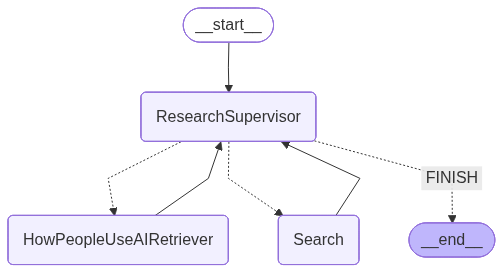

In [40]:
compiled_research_graph

The next part is key - since we need to "wrap" our LangGraph in order for it to be compatible in the following steps - let's create an LCEL chain out of it!

This allows us to "broadcast" messages down to our Research Team LangGraph!

In [41]:
def enter_research_chain(message: str):
    results = {
        "messages": [HumanMessage(content=message)],
    }
    return results

research_chain = enter_research_chain | compiled_research_graph

Now, finally, we can take it for a spin!

In [42]:
for s in research_chain.stream(
    "How are people using AI to improve their lives?", {"recursion_limit": 100}
):
    if "__end__" not in s:
        print(s)
        print("---")

{'ResearchSupervisor': {'next': 'HowPeopleUseAIRetriever'}}
---
{'HowPeopleUseAIRetriever': {'messages': [HumanMessage(content="People are using AI, such as ChatGPT, to improve their lives in various ways. Here are some significant applications:\n\n1. **Education and Tutoring**: Many users seek practical guidance for tutoring or teaching, which constitutes a major use case for AI. This includes requests for how-to advice on various topics.\n\n2. **Technical Help**: AI is utilized for technical assistance, including computer programming, mathematical calculations, and data analysis. This technical support can help individuals navigate complex tasks more efficiently.\n\n3. **Self-Expression and Entertainment**: Users engage AI for personal expression, reflection on relationships, and entertainment through games and role play. This fosters a creative outlet for many people.\n\n4. **Customized Content Generation**: AI's ability to produce customized and novel content enables users to recei

##### 🏗️ Activity #2:

Using whatever drawing application you wish - please label the flow above on a diagram of your graph.

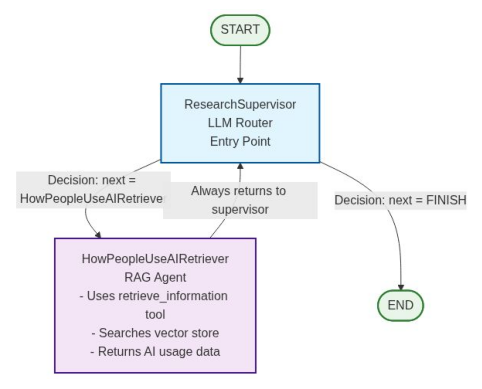

In [ ]:
#### Answer
import base64
import io, requests
from IPython.display import Image, display
from PIL import Image as im
import matplotlib.pyplot as plt

def mm(graph):
    graphbytes = graph.encode("utf8")
    base64_bytes = base64.urlsafe_b64encode(graphbytes)
    base64_string = base64_bytes.decode("ascii")
    img = im.open(io.BytesIO(requests.get('https://mermaid.ink/img/' + base64_string).content))
    plt.imshow(img)
    plt.axis('off') # allow to hide axis
    plt.savefig('image.png', dpi=1200)

mm("""
flowchart TD
    START([START]) --> ResearchSupervisor[ResearchSupervisor<br/>LLM Router<br/>Entry Point]
    
    ResearchSupervisor -->|Decision: next = HowPeopleUseAIRetriever| HowPeopleUseAIRetriever[HowPeopleUseAIRetriever<br/>RAG Agent<br/>- Uses retrieve_information tool<br/>- Searches vector store<br/>- Returns AI usage data]
    
    
    HowPeopleUseAIRetriever -->|Always returns to supervisor| ResearchSupervisor
    
    ResearchSupervisor -->|Decision: next = FINISH| END([END])
    
    classDef supervisor fill:#e1f5fe,stroke:#01579b,stroke-width:2px
    classDef agent fill:#f3e5f5,stroke:#4a148c,stroke-width:2px
    classDef terminal fill:#e8f5e8,stroke:#2e7d32,stroke-width:2px
    
    class ResearchSupervisor supervisor
    class HowPeopleUseAIRetriever,Search agent
    class START,END terminal
""")

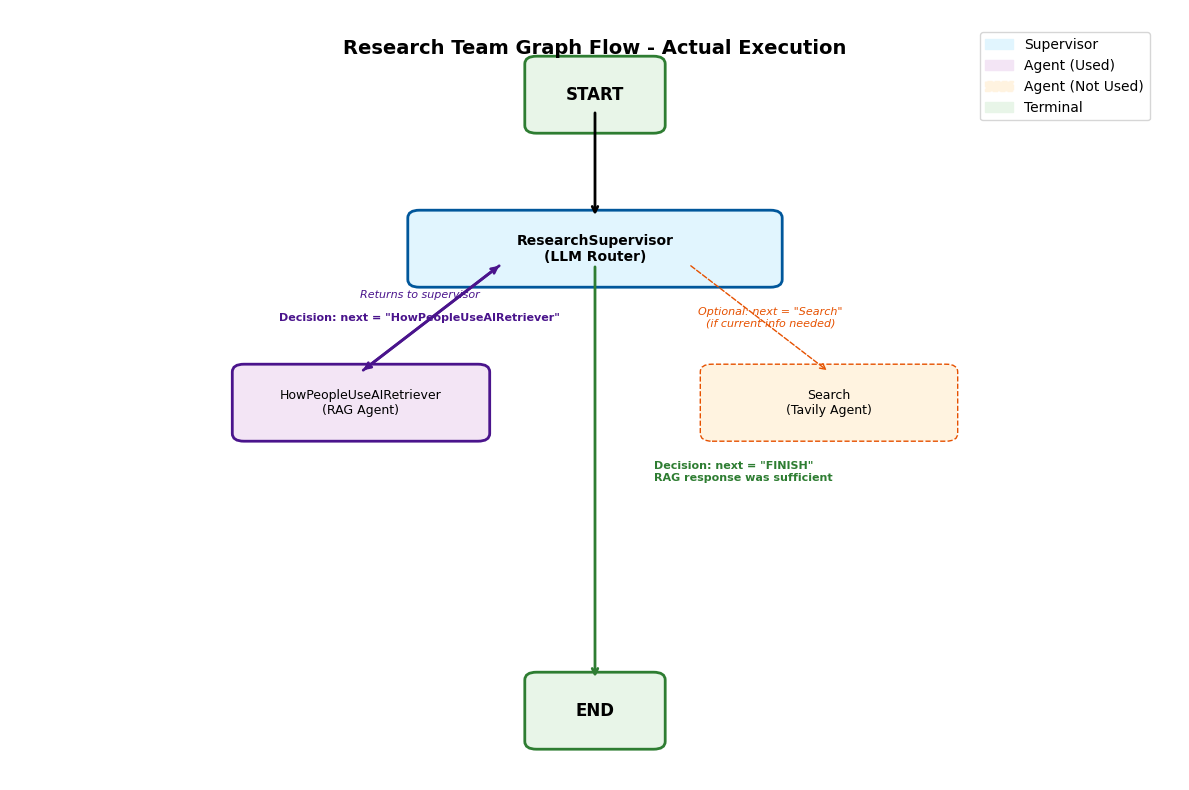

In [ ]:
#Alternate flow diagram - shows all paths and the ones not called in dotted lines 
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.patches import FancyBboxPatch, ConnectionPatch
import numpy as np

# Create figure and axis
fig, ax = plt.subplots(1, 1, figsize=(12, 8))
ax.set_xlim(0, 10)
ax.set_ylim(0, 10)
ax.axis('off')

# Define colors
supervisor_color = '#e1f5fe'
agent_color = '#f3e5f5'
terminal_color = '#e8f5e8'
optional_color = '#fff3e0'

# Define positions
positions = {
    'START': (5, 9),
    'ResearchSupervisor': (5, 7),
    'HowPeopleUseAIRetriever': (3, 5),
    'Search': (7, 5),
    'END': (5, 1)
}

# Draw START node
start_box = FancyBboxPatch((4.5, 8.5), 1, 0.8, 
                          boxstyle="round,pad=0.1", 
                          facecolor=terminal_color, 
                          edgecolor='#2e7d32', 
                          linewidth=2)
ax.add_patch(start_box)
ax.text(5, 8.9, 'START', ha='center', va='center', fontsize=12, fontweight='bold')

# Draw ResearchSupervisor node
supervisor_box = FancyBboxPatch((3.5, 6.5), 3, 0.8, 
                               boxstyle="round,pad=0.1", 
                               facecolor=supervisor_color, 
                               edgecolor='#01579b', 
                               linewidth=2)
ax.add_patch(supervisor_box)
ax.text(5, 6.9, 'ResearchSupervisor\n(LLM Router)', ha='center', va='center', fontsize=10, fontweight='bold')

# Draw HowPeopleUseAIRetriever node (actual path)
rag_box = FancyBboxPatch((2, 4.5), 2, 0.8, 
                        boxstyle="round,pad=0.1", 
                        facecolor=agent_color, 
                        edgecolor='#4a148c', 
                        linewidth=2)
ax.add_patch(rag_box)
ax.text(3, 4.9, 'HowPeopleUseAIRetriever\n(RAG Agent)', ha='center', va='center', fontsize=9)

# Draw Search node (optional path - dashed)
search_box = FancyBboxPatch((6, 4.5), 2, 0.8, 
                           boxstyle="round,pad=0.1", 
                           facecolor=optional_color, 
                           edgecolor='#e65100', 
                           linewidth=1,
                           linestyle='--')
ax.add_patch(search_box)
ax.text(7, 4.9, 'Search\n(Tavily Agent)', ha='center', va='center', fontsize=9)

# Draw END node
end_box = FancyBboxPatch((4.5, 0.5), 1, 0.8, 
                        boxstyle="round,pad=0.1", 
                        facecolor=terminal_color, 
                        edgecolor='#2e7d32', 
                        linewidth=2)
ax.add_patch(end_box)
ax.text(5, 0.9, 'END', ha='center', va='center', fontsize=12, fontweight='bold')

# Draw arrows - actual flow (solid lines)
# START to ResearchSupervisor
ax.annotate('', xy=(5, 7.3), xytext=(5, 8.7),
            arrowprops=dict(arrowstyle='->', lw=2, color='black'))

# ResearchSupervisor to HowPeopleUseAIRetriever (actual path)
ax.annotate('', xy=(3, 5.3), xytext=(4.2, 6.7),
            arrowprops=dict(arrowstyle='->', lw=2, color='#4a148c'))
ax.text(3.5, 6, 'Decision: next = "HowPeopleUseAIRetriever"', 
        ha='center', va='center', fontsize=8, color='#4a148c', fontweight='bold')

# HowPeopleUseAIRetriever back to ResearchSupervisor
ax.annotate('', xy=(4.2, 6.7), xytext=(3, 5.3),
            arrowprops=dict(arrowstyle='->', lw=2, color='#4a148c'))
ax.text(3.5, 6.3, 'Returns to supervisor', 
        ha='center', va='center', fontsize=8, color='#4a148c', style='italic')

# ResearchSupervisor to END
ax.annotate('', xy=(5, 1.3), xytext=(5, 6.7),
            arrowprops=dict(arrowstyle='->', lw=2, color='#2e7d32'))
ax.text(5.5, 4, 'Decision: next = "FINISH"\nRAG response was sufficient', 
        ha='left', va='center', fontsize=8, color='#2e7d32', fontweight='bold')

# Draw optional path (dashed line)
ax.annotate('', xy=(7, 5.3), xytext=(5.8, 6.7),
            arrowprops=dict(arrowstyle='->', lw=1, color='#e65100', linestyle='--'))
ax.text(6.5, 6, 'Optional: next = "Search"\n(if current info needed)', 
        ha='center', va='center', fontsize=8, color='#e65100', style='italic')

# Add title
ax.text(5, 9.5, 'Research Team Graph Flow - Actual Execution', 
        ha='center', va='center', fontsize=14, fontweight='bold')

# Add legend
legend_elements = [
    patches.Patch(color=supervisor_color, label='Supervisor'),
    patches.Patch(color=agent_color, label='Agent (Used)'),
    patches.Patch(color=optional_color, label='Agent (Not Used)', linestyle='--'),
    patches.Patch(color=terminal_color, label='Terminal')
]
ax.legend(handles=legend_elements, loc='upper right', bbox_to_anchor=(0.98, 0.98))

plt.tight_layout()
plt.show()


##### 🏗️ Activity #2:


##### ❓ Question #2:

How could you make sure your Agent uses specific tools that you wish it to use? Are there any ways to concretely set a flow through tools?

##### ✅ Answer:
We can use the 'tool_choice' parameter to ensure a specific tool is called . Not sure if we can tie and agent a tool together and then add edges in a predeterministic manner and since there is only one tool choice - it is would be called. 
Few shot examples, specific trigger phases and clear instructions could also help in making a flow more deterministic. or we can make each tool a node and then connect those nodes in te sequence we want.




# 🤝 BREAKOUT ROOM #2

## Task 4: Document Writing Team - A LangGraph for Planning, Writing, and Editing a Formal Research Resport.

Let's run it all back, this time specifically creating tools, agent nodes, and a graph for Planning, Writing, and Editing a Formal Research Resport!

#### Previous Cohort Use Case Data

Let's add a retriever for [previous cohort use-case data](./data/AIE7_Projects_with_Domains.csv) here!

This will allow our response writing team reference previous responses!

In [51]:
from langchain_community.document_loaders import CSVLoader

previous_cohort_loader = CSVLoader("data/AIE7_Projects_with_Domains.csv", content_columns=["Project Domain", "Secondary Domain (if any)"])
previous_cohort = previous_cohort_loader.load()
previous_cohort[0]

Document(metadata={'source': 'data/AIE7_Projects_with_Domains.csv', 'row': 0}, page_content='Project Domain: Customer Support / Helpdesk\nSecondary Domain (if any): Productivity Assistants')

In [52]:
qdrant_previous_cohort_vectorstore = Qdrant.from_documents(
    documents=previous_cohort,
    embedding=embedding_model,
    location=":memory:"
)

In [53]:
qdrant_previous_cohort_retriever = qdrant_previous_cohort_vectorstore.as_retriever()

### Tool Creation

Let's create some tools that will help us understand, open, work with, and edit documents to our liking!

In [54]:
from pathlib import Path
from tempfile import TemporaryDirectory
from typing import Dict, Optional
from typing_extensions import TypedDict
import uuid
import os

os.makedirs('./content/data', exist_ok=True)

def create_random_subdirectory():
    random_id = str(uuid.uuid4())[:8]  # Use first 8 characters of a UUID
    subdirectory_path = os.path.join('./content/data', random_id)
    os.makedirs(subdirectory_path, exist_ok=True)
    return subdirectory_path

WORKING_DIRECTORY = Path(create_random_subdirectory())

@tool
def create_outline(
    points: Annotated[List[str], "List of main points or sections."],
    file_name: Annotated[str, "File path to save the outline."],
) -> Annotated[str, "Path of the saved outline file."]:
    """Create and save an outline."""
    with (WORKING_DIRECTORY / file_name).open("w") as file:
        for i, point in enumerate(points):
            file.write(f"{i + 1}. {point}\n")
    return f"Outline saved to {file_name}"


@tool
def read_document(
    file_name: Annotated[str, "File path to save the document."],
    start: Annotated[Optional[int], "The start line. Default is 0"] = None,
    end: Annotated[Optional[int], "The end line. Default is None"] = None,
) -> str:
    """Read the specified document."""
    with (WORKING_DIRECTORY / file_name).open("r") as file:
        lines = file.readlines()
    if start is not None:
        start = 0
    return "\n".join(lines[start:end])

@tool
def write_document(
    content: Annotated[str, "Text content to be written into the document."],
    file_name: Annotated[str, "File path to save the document."],
) -> Annotated[str, "Path of the saved document file."]:
    """Create and save a text document."""
    with (WORKING_DIRECTORY / file_name).open("w") as file:
        file.write(content)
    return f"Document saved to {file_name}"

### Previous Cohort Use Case Data
@tool 
def reference_previous_responses(
    query: Annotated[str, "The query to search for in the previous responses."],
) -> Annotated[str, "The previous responses that match the query."]:
    """Search for previous responses that match the query."""
    return qdrant_previous_cohort_retriever.invoke(query)


@tool
def edit_document(
    file_name: Annotated[str, "Path of the document to be edited."],
    inserts: Annotated[
        Dict[int, str],
        "Dictionary where key is the line number (1-indexed) and value is the text to be inserted at that line.",
    ] = {},
) -> Annotated[str, "Path of the edited document file."]:
    """Edit a document by inserting text at specific line numbers."""

    with (WORKING_DIRECTORY / file_name).open("r") as file:
        lines = file.readlines()

    sorted_inserts = sorted(inserts.items())

    for line_number, text in sorted_inserts:
        if 1 <= line_number <= len(lines) + 1:
            lines.insert(line_number - 1, text + "\n")
        else:
            return f"Error: Line number {line_number} is out of range."

    with (WORKING_DIRECTORY / file_name).open("w") as file:
        file.writelines(lines)

    return f"Document edited and saved to {file_name}"

##### 🏗️ Activity #3:

Describe, briefly, what each of these tools is doing in your own words.


##### ✅ Answer:
We define custom tools for the document editing and management part of this system. These tools are :
1. create_random_subdirectory: Directory Setup : Creates a unique (using uuid) working director for each session that all tools share.
2. create_outline: Takes a list of main points and filename and saves a number list of the points to a file 
3. read_document: Reads the provided document from the directory - it can read specified number of lines (start,end) or the entire doc
4. write_document: creates new documents in overwrite (w) mode with content (input)
5. reference_previous_responses: searches through previous responses (previous cohort data) using RAG for answers to the given query
6. edit_document : Inserts new content at specific line numbers
The tools together form a collaborative workflow to read, outline, write and update documents while referencing previous work in a shared directory

### Document Writing State

Just like with our Research Team state - we want to keep track of a few things, however this time - we also want to keep track of which files we've created - so let's add that here!

In [36]:
import operator
from pathlib import Path

class DocWritingState(TypedDict):
    messages: Annotated[List[BaseMessage], operator.add]
    team_members: str
    next: str
    current_files: str

### Document Writing Prelude Function

Since we have a working directory - we want to be clear about what our current working directory looks like - this helper function will allow us to do that cleanly!

In [37]:
def prelude(state):
    written_files = []
    if not WORKING_DIRECTORY.exists():
        WORKING_DIRECTORY.mkdir()
    try:
        written_files = [
            f.relative_to(WORKING_DIRECTORY) for f in WORKING_DIRECTORY.rglob("*")
        ]
    except:
        pass
    if not written_files:
        return {**state, "current_files": "No files written."}
    return {
        **state,
        "current_files": "\nBelow are files your team has written to the directory:\n"
        + "\n".join([f" - {f}" for f in written_files]),
    }

### Document Writing Node Creation



In [38]:
authoring_llm = ChatOpenAI(model="gpt-4o-mini")

In [39]:
doc_writer_agent = create_agent(
    authoring_llm,
    [write_document, edit_document, read_document],
    ("You are an expert writing customer assistance responses.\n"
    "Below are files currently in your directory:\n{current_files}"),
)
context_aware_doc_writer_agent = prelude | doc_writer_agent
doc_writing_node = functools.partial(
    agent_node, agent=context_aware_doc_writer_agent, name="DocWriter"
)

note_taking_agent = create_agent(
    authoring_llm,
    [create_outline, read_document, reference_previous_responses],
    ("You are an expert senior researcher tasked with writing a customer assistance outline and"
    " taking notes to craft a customer assistance response.\n{current_files}"),
)
context_aware_note_taking_agent = prelude | note_taking_agent
note_taking_node = functools.partial(
    agent_node, agent=context_aware_note_taking_agent, name="NoteTaker"
)

copy_editor_agent = create_agent(
    authoring_llm,
    [write_document, edit_document, read_document],
    ("You are an expert copy editor who focuses on fixing grammar, spelling, and tone issues\n"
    "Below are files currently in your directory:\n{current_files}"),
)
context_aware_copy_editor_agent = prelude | copy_editor_agent
copy_editing_node = functools.partial(
    agent_node, agent=context_aware_copy_editor_agent, name="CopyEditor"
)

authoring_supervisor_agent = create_team_supervisor(
    authoring_llm,
    ("You are a supervisor tasked with managing a conversation between the"
    " following workers: {team_members}. You should always verify the technical"
    " contents after any edits are made. "
    "Given the following user request,"
    " respond with the worker to act next. Each worker will perform a"
    " task and respond with their results and status. When each team is finished,"
    " you must respond with FINISH."),
    ["DocWriter", "NoteTaker", "CopyEditor"],
)

### Document Writing Team LangGraph Construction

This part is almost exactly the same (with a few extra nodes) as our Research Team LangGraph construction - so we'll leave it as one block!

In [40]:
authoring_graph = StateGraph(DocWritingState)
authoring_graph.add_node("DocWriter", doc_writing_node)
authoring_graph.add_node("NoteTaker", note_taking_node)
authoring_graph.add_node("CopyEditor", copy_editing_node)
authoring_graph.add_node("AuthoringSupervisor", authoring_supervisor_agent)

authoring_graph.add_edge("DocWriter", "AuthoringSupervisor")
authoring_graph.add_edge("NoteTaker", "AuthoringSupervisor")
authoring_graph.add_edge("CopyEditor", "AuthoringSupervisor")

authoring_graph.add_conditional_edges(
    "AuthoringSupervisor",
    lambda x: x["next"],
    {
        "DocWriter": "DocWriter",
        "NoteTaker": "NoteTaker",
        "CopyEditor" : "CopyEditor",
        "FINISH": END,
    },
)

authoring_graph.set_entry_point("AuthoringSupervisor")

In [41]:
compiled_authoring_graph = authoring_graph.compile()

#### Display Graph

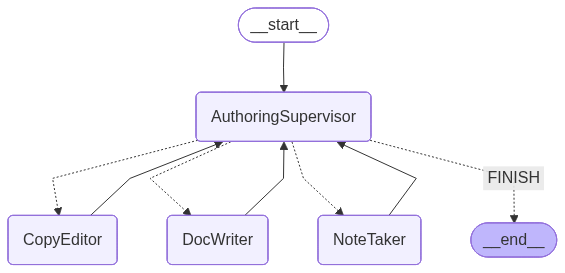

In [42]:
compiled_authoring_graph

Just as before - we'll need to create an "interface" between the level above, and our graph.

In [43]:
def enter_authoring_chain(message: str, members: List[str]):
    results = {
        "messages": [HumanMessage(content=message)],
        "team_members": ", ".join(members),
    }
    return results

authoring_chain = (
    functools.partial(enter_authoring_chain, members=authoring_graph.nodes)
    | compiled_authoring_graph
)

Now we can test this out!

> NOTE: It is possible you may see an error here - rerun the cell to clear.

In [44]:
for s in authoring_chain.stream(
    "What are the most common use-cases in this data. What are the most common domains?",
    {"recursion_limit": 100},
):
    if "__end__" not in s:
        print(s)
        print("---")

{'AuthoringSupervisor': {'next': 'DocWriter'}}
---
{'DocWriter': {'messages': [HumanMessage(content='The most common use-cases and domains in customer assistance typically include:\n\n1. **E-commerce and Retail**:\n   - Order tracking and management\n   - Product inquiries and recommendations\n   - Returns and refunds assistance\n   - Payment and billing inquiries\n\n2. **Technology and Software**:\n   - Technical support for software issues\n   - Troubleshooting hardware problems\n   - Account management and security queries\n   - Product feature explanations\n\n3. **Telecommunications**:\n   - Service activation and cancellation\n   - Billing disputes and payment options\n   - Plan changes and upgrades\n   - Network issues and troubleshooting\n\n4. **Travel and Hospitality**:\n   - Booking and reservation management\n   - Cancellation and refund requests\n   - Travel itinerary inquiries\n   - Customer loyalty program assistance\n\n5. **Healthcare and Insurance**:\n   - Appointment sc

## Task 5: Meta-Supervisor and Full Graph

Finally, now that we have our two LangGraph agents (some of which are already multi-agent), we can build a supervisor that sits above all of them!

The final process, surprisingly, is quite straight forward!

Let's jump in!

First off - we'll need to create our supervisor agent node.

In [45]:
from langchain_core.messages import AIMessage, BaseMessage, HumanMessage
from langchain_openai.chat_models import ChatOpenAI

super_llm = ChatOpenAI(model="gpt-4o-mini")

super_supervisor_agent = create_team_supervisor(
    super_llm,
    "You are a supervisor tasked with managing a conversation between the"
    " following teams: {team_members}. Given the following user request,"
    " respond with the worker to act next. Each worker will perform a"
    " task and respond with their results and status. When all workers are finished,"
    " you must respond with FINISH.",
    ["Research team", "Response team"],
)

We'll also create our new state - as well as some methods to help us navigate the new state and the subgraphs.

> NOTE: We only pass the most recent message from the parent graph to the subgraph, and we only extract the most recent message from the subgraph to include in the state of the parent graph.

In [46]:
class State(TypedDict):
    messages: Annotated[List[BaseMessage], operator.add]
    next: str

def get_last_message(state: State) -> str:
    return state["messages"][-1].content

def join_graph(response: dict):
    return {"messages": [response["messages"][-1]]}

Next, we'll create our base graph.

Notice how each node we're adding is *AN ENTIRE LANGGRAPH AGENT* (wrapped into an LCEL chain with our helper functions above).

In [47]:
super_graph = StateGraph(State)

super_graph.add_node("Research team", get_last_message | research_chain | join_graph)
super_graph.add_node("Response team", get_last_message | authoring_chain | join_graph)
super_graph.add_node("SuperSupervisor", super_supervisor_agent)

Next, we'll create our edges!

This process is completely idenctical to what we've seen before - just addressing the LangGraph subgraph nodes instead of individual nodes.

In [48]:
super_graph.add_edge("Research team", "SuperSupervisor")
super_graph.add_edge("Response team", "SuperSupervisor")
super_graph.add_conditional_edges(
    "SuperSupervisor",
    lambda x: x["next"],
    {
        "Response team": "Response team",
        "Research team": "Research team",
        "FINISH": END,
    },
)
super_graph.set_entry_point("SuperSupervisor")

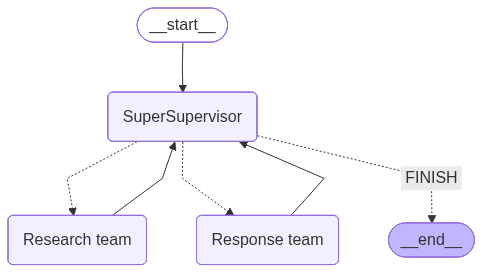

In [49]:
compiled_super_graph = super_graph.compile()
compiled_super_graph

That's it!

Now we can finally use our full agent!

In [50]:
WORKING_DIRECTORY = Path(create_random_subdirectory())

for s in compiled_super_graph.stream(
    {
        "messages": [
            HumanMessage(
                content="Write a report on the rise of context engineering in the LLM Space in 2025, and how it's impacting how people are using AI."
            )
        ],
    },
    {"recursion_limit": 30},
):
    if "__end__" not in s:
        print(s)
        print("---")

{'SuperSupervisor': {'next': 'Research team'}}
---
{'Research team': {'messages': [HumanMessage(content='# Report on the Rise of Context Engineering in the LLM Space (2025)\n\n## Introduction\nIn 2025, the interaction between humans and Artificial Intelligence (AI)—specifically through Large Language Models (LLMs)—has markedly evolved due to the rise of context engineering. This burgeoning field is reshaping how users engage with AI technology, promoting more effective and tailored applications across a spectrum of industries.\n\n## Understanding Context Engineering\nContext engineering can be defined as the art and science of creating and managing the framework within which AI operates, focusing on optimizing the significance of context to improve user interactions. Rather than merely feeding extended prompts into an AI system, context engineering aims to fine-tune the inputs and manage the flow of information to enhance comprehension and relevancy in AI responses. This careful curati

## SAMPLE POST!

### Report on the Rise of Context Engineering in the LLM Space in 2025

#### Introduction
As we move further into 2025, the landscape of artificial intelligence continues to evolve, particularly in the domain of large language models (LLMs). One significant trend emerging is "context engineering," which has begun to outpace the earlier focus on prompt engineering. This report explores how context engineering is reshaping the dynamics of AI usage, enhancing the capabilities of LLMs to perform complex tasks, and ultimately influencing the way users interact with AI technologies.

#### The Emergence of Context Engineering
In previous years, prompt engineering involved crafting inputs to guide LLMs to generate desired outputs. However, by 2025, the limitations of traditional prompt engineering have become evident, especially as applications require more dynamic interactions and multi-turn dialogues. Context engineering has emerged as a new paradigm, prioritizing the construction of strategies and systems that enable LLMs to access and utilize extensive contextual information effectively.

Modern LLMs, such as GPT-4 Turbo and Claude 3, now boast context windows that can handle up to 1 million tokens. This substantial increase allows these models to grasp more extensive content, such as books or lengthy documents, fundamentally changing what they can achieve in real-world applications.

#### Key Developments in Context Engineering
1. **Dynamic Knowledge Management**: The shift towards context engineering facilitates more sophisticated knowledge management within AI systems. These systems now use persistent memory and adaptive reasoning, enabling them to maintain context across interactions. For example, agent-based LLMs can now engage in workflows requiring multiple exchanges, which is vital for complex applications requiring follow-ups and extended dialogues.

2. **Improved Context Lengths**: Advances in transformer architectures have led to the possibility of extending native context lengths dramatically. As a result, LLMs can process larger datasets directly, enhancing their capacity to deliver accurate and relevant outputs without extensive re-prompting.

3. **Context Compression and Retrieval**: Techniques such as context compression, where information is stored externally or synthesized to maximize relevance, are gaining traction. Methods identified in recent studies highlight the importance of integrating efficient retrieval systems and summarization techniques to make the most of the available context.

4. **The Rise of Multi-Agent Systems**: In 2025, LLM applications are increasingly shifting towards multi-agent architectures, where different AI agents work collaboratively, leveraging various tools and pieces of information to improve output accuracy and reduce operational inefficiencies.

#### Impact on AI Usage
The implications of context engineering are far-reaching and transformative for users and organizations:

- **Enhanced Accuracy**: Enterprises adopting context engineering report accuracy rates of 90-95%, a significant improvement over the 65-75% typically associated with earlier methods. This rise in performance is generating more trust in AI systems across various sectors.

- **Faster Deployment and Cost Efficiency**: Organizations employing structured context engineering have demonstrated a 3x increase in the speed of bringing AI solutions to production and a 40% reduction in operational costs compared to traditional prompt-based methodologies.

- **Adaptability and Scalability**: Context-engineered systems are inherently more adaptable, allowing businesses to scale AI applications rapidly in response to evolving needs without overhauling the underlying architecture.

- **Augmentation of Human Intelligence**: As context engineering allows AI systems to interact in more meaningful ways, they are increasingly positioned as partners in decision-making processes, rather than mere tools. This evolution enhances the collaborative potential between humans and AI.

#### Conclusion
The rise of context engineering marks a critical turning point in the development and application of LLMs. As AI systems become increasingly capable of managing and utilizing complex contextual information, they are set to enhance user experiences, improve efficiency, and drive new innovations across industries. Organizations that embrace this trend will likely lead the charge into a future where AI is not just a tool for automation but a collaborative partner in problem-solving and creativity.